# Developing a model architecture for glioma classification

## Packages to use

In [1]:
## Imports go here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import nibabel as nib
import scikeras

from sklearn.model_selection import train_test_split

import tensorflow as tf
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report

2023-03-10 16:39:06.890150: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-10 16:39:06.999747: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-10 16:39:07.006592: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-10 16:39:07.006607: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

## Working with data

In [4]:
#load the dataframe
df = pd.read_pickle("../raw_data/Grade_ID_t1_nii.pkl")

# the target columns have to be updated, it's only the fremework
df['Grade'] = df['Grade'].apply(lambda x: 0 if x == 'HGG' else 1)

# cut the image to smaller to match the location of brain
df['t1_nii']= df['t1_nii'].apply(lambda x: np.array(x[40:195,35:225,1:145]))

# split the Train and test
X_train, X_test, y_train, y_test = train_test_split(df['t1_nii'], df['Grade'], test_size=0.2, random_state=42)


In [5]:
# banlance the X_train
over_sampler = RandomOverSampler(random_state=42)
X_res, y_res = over_sampler.fit_resample(pd.DataFrame(X_train), y_train)
# change the X_train to match the input of tensorfolw
X_res = X_res['t1_nii']
X_res = np.array([np.array(val) for val in X_res])
X_res = X_res.reshape(len(X_res), 155, 190, 144, 1)
X_res.shape

(460, 155, 190, 144, 1)

In [52]:
X_train.iloc[0]

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

## Model architecture - CNN

In [6]:
input_shape = (155, 190, 144, 1)
#around 295 observations

In [7]:
#we need 1 kernel as we have 1 label for segmentation, kernel size = 3x3x3?

#initialize model
def initialize_model(dropout = 0.5, dense_1 = 50, \
    learning_rate = 0.1, kernel_size=(8,8,8), pool_size = (2,2,2)):
    model = Sequential()
    
    #Add convo layers to the model
    model.add(Conv3D(16, kernel_size=kernel_size, activation='relu', input_shape=input_shape))
    # model.add(MaxPooling3D(pool_size=pool_size))
    # model.add(Conv3D(64, kernel_size=kernel_size, activation='relu'))
    # model.add(MaxPooling3D(pool_size=pool_size))
    # model.add(Conv3D(128, kernel_size=kernel_size, activation='relu'))
    # model.add(MaxPooling3D(pool_size=pool_size))
    
    #Add a flatten layer
    model.add(Flatten())
    
    #maybe add age here for the second model
     
    #Add dense levels
    # model.add(Dense(dense_1, activation='relu'))
    # model.add(Dropout(dropout))

    
    #Add layer with activation
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    #Model compilation
    optim=Adam(learning_rate=learning_rate)
    model.compile(loss = 'binary_crossentropy',
                  optimizer = optim,
                  metrics = ['accuracy'])
    return model


In [8]:
#instantiate a model
model_seg = initialize_model()
model_seg.summary()

2023-03-10 16:41:06.317261: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-10 16:41:06.317311: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-10 16:41:06.317349: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (brain-project-cpu): /proc/driver/nvidia/version does not exist
2023-03-10 16:41:06.317991: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 148, 183, 137, 16  8208      
                             )                                   
                                                                 
 flatten (Flatten)           (None, 59368128)          0         
                                                                 
 dense (Dense)               (None, 16)                949890064 
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 949,898,289
Trainable params: 949,898,289
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# with using GPU if you have one
with tf.device('/device:gpu:1'):
    # Do something

In [9]:
#baseline model score

es = EarlyStopping(patience=3, restore_best_weights = True)
history = model_seg.fit(X_res, y_res,
                        epochs = 12,
                        batch_size = 32,
                        callbacks = [es],
                        validation_split = 0.2,
                        shuffle =True,
                        verbose = 1 
                        )

Epoch 1/12
12/12 [==============================] - 92s 7s/step - loss: 552902848.0000 - accuracy: 0.5842 - val_loss: 0.7864 - val_accuracy: 0.0000e+00
Epoch 2/12
12/12 [==============================] - 80s 7s/step - loss: 0.6664 - accuracy: 0.6250 - val_loss: 0.9652 - val_accuracy: 0.0000e+00
Epoch 3/12
12/12 [==============================] - 81s 7s/step - loss: 0.6669 - accuracy: 0.6250 - val_loss: 1.0907 - val_accuracy: 0.0000e+00
Epoch 4/12
12/12 [==============================] - 81s 7s/step - loss: 0.6636 - accuracy: 0.6250 - val_loss: 0.9773 - val_accuracy: 0.0000e+00


In [10]:
#plot the learning curve
def plot_loss(history):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,4))
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])
    ax1.set_title('Model loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylim(ymin=0, ymax=1)
    ax1.legend(['Train', 'Validation'], loc='best')
    ax1.grid(axis="x",linewidth=0.5)
    ax1.grid(axis="y",linewidth=0.5)    
    
    ax2.plot(history.history['accuracy'])
    ax2.plot(history.history['val_accuracy'])
    ax2.set_title('Accuracy')
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylim(ymin=0, ymax=1)
    ax2.legend(['Train', 'Validation'], loc='best')
    ax2.grid(axis="x",linewidth=0.5)
    ax2.grid(axis="y",linewidth=0.5)    

    plt.show()    

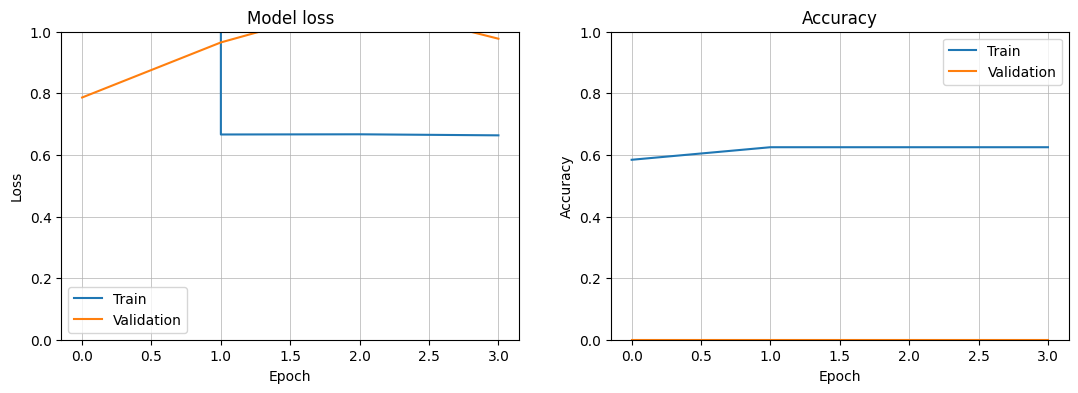

In [11]:
plot_loss(history)

In [12]:
X_test = np.array([np.array(val) for val in X_test])
X_test = X_test.reshape(len(X_test), 155, 190, 144, 1)
X_test.shape

(74, 155, 190, 144, 1)

In [13]:
y_pred = model_seg.predict(X_test)

3/3 [==============================] - 7s 2s/step


In [14]:
predictions = (model_seg.predict(X_test) > 0.5).astype("int32")

3/3 [==============================] - 6s 2s/step


In [15]:
predictions.shape

(74, 1)

In [19]:
predictions.sum()


0

In [20]:
y_pred

array([[0.45548373],
       [0.45548373],
       [0.45548373],
       [0.45548373],
       [0.45548373],
       [0.45548373],
       [0.45548373],
       [0.45548373],
       [0.45548373],
       [0.45548373],
       [0.45548373],
       [0.45548373],
       [0.45548373],
       [0.45548373],
       [0.45548373],
       [0.45548373],
       [0.45548373],
       [0.45548373],
       [0.45548373],
       [0.45548373],
       [0.45548373],
       [0.45548373],
       [0.45548373],
       [0.45548373],
       [0.45548373],
       [0.45548373],
       [0.45548373],
       [0.45548373],
       [0.45548373],
       [0.45548373],
       [0.45548373],
       [0.45548373],
       [0.45548373],
       [0.45548373],
       [0.45548373],
       [0.45548373],
       [0.45548373],
       [0.45548373],
       [0.45548373],
       [0.45548373],
       [0.45548373],
       [0.45548373],
       [0.45548373],
       [0.45548373],
       [0.45548373],
       [0.45548373],
       [0.45548373],
       [0.455

In [12]:
model_seg.evaluate(X_test, y_test)

3/3 [==============================] - 6s 2s/step - loss: 2.0148 - accuracy: 0.7162


[2.014842987060547, 0.7162162065505981]

In [21]:
predictions=pd.DataFrame(predictions)
predictions.value_counts()

0    74
dtype: int64

In [33]:
from sklearn.metrics import classification_report

target_names = ['class 0', 'class 1']
print(classification_report(y_test, predictions, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.86      0.79      0.83        63
     class 1       0.19      0.27      0.22        11

    accuracy                           0.72        74
   macro avg       0.52      0.53      0.52        74
weighted avg       0.76      0.72      0.74        74



In [36]:
keras_estimator = KerasClassifier(build_fn = initialize_model, verbose = 1)

/var/folders/mz/tl4yflb54ks27kzvc57r1qvw0000gn/T/ipykernel_99831/1004603991.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_estimator = KerasClassifier(build_fn = initialize_model, verbose = 1)


In [37]:
estimator = Pipeline([('kc', keras_estimator)])

In [53]:
keras_estimator

{'verbose': 1,
 'build_fn': <function __main__.initialize_model(dropout=0.5, dense_1=50, learning_rate=0.01, kernel_size=(3, 3, 3), pool_size=(2, 2, 2))>}

In [54]:
estimator.get_params()#.get("kc__verbose")


{'memory': None,
 'steps': [('kc',
   <keras.wrappers.scikit_learn.KerasClassifier at 0x15feb1bd0>)],
 'verbose': False,
 'kc': <keras.wrappers.scikit_learn.KerasClassifier at 0x15feb1bd0>,
 'kc__verbose': 1,
 'kc__build_fn': <function __main__.initialize_model(dropout=0.5, dense_1=50, learning_rate=0.01, kernel_size=(3, 3, 3), pool_size=(2, 2, 2))>}

In [39]:
#hyperparameters tuning
# Define the hyperparameters
param_grid = {
    'kc__dense_1': [20, 30, 50, 100],
    'kc__kernel_size': [(2,2,2),(3,3,3), (5,5,5), (7,7,7)],
    'kc__pool_size': [(2,2,2),(3,3,3)],
    'kc__batch_size':[8, 16, 32],
    'kc__dropout': [0.5, 0.4, 0.3, 0.2, 0.1, 0],
    'kc__learning_rate': [0.001, 0.01, 0.1]
}


In [40]:
kfold_splits = 5
grid = GridSearchCV(estimator=estimator,  
                    n_jobs=-1, 
                    verbose=1,
                    return_train_score=True,
                    cv=kfold_splits,  #StratifiedKFold(n_splits=kfold_splits, shuffle=True)
                    param_grid=param_grid,)

In [ ]:
grid_result = grid.fit(X, y) #callbacks=[tbCallBack]

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
y_pred = model_seg.predict(X_test)

In [ ]:
#prediction with the final model 
model_seg.evaluate(X_test, y_test)

## Model acrhitecture - UNET

In [ ]:
#maybe we don't need it for now, will check later

## Model architecture - 2D CNN

In [ ]:
#maybe we don't need it for now, will check later